### Задача проекта - предсказать недельные продажи (Weekly_Sales) для каждого наблюдения на основе временных, погодных и макроэкономических признаков. Поскольку данные имеют временную структуру и выраженную сезонность, для анализа и моделирования будет использоваться временное разделение выборки.

#### подключение к таблице

In [33]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('/home/aroya/sales-forecast/data/sales.db') # подключаемся к sql
df = pd.read_sql_query("select * from sales_raw", conn) # читаем данные из sql в dataframe
conn.close()

#### первычиный осмотр данных

In [34]:
df.head() # вывподимм первые 5 строк для ознакомления с таблицей

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [35]:
df.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


целевая переменная числовая

In [36]:
df.describe() # статистические данные по каждому атрибуту (столбцу)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [37]:
df.isnull().sum() # количество null значений

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

#### графики распределения целевой переменной (Weekly_Sales)

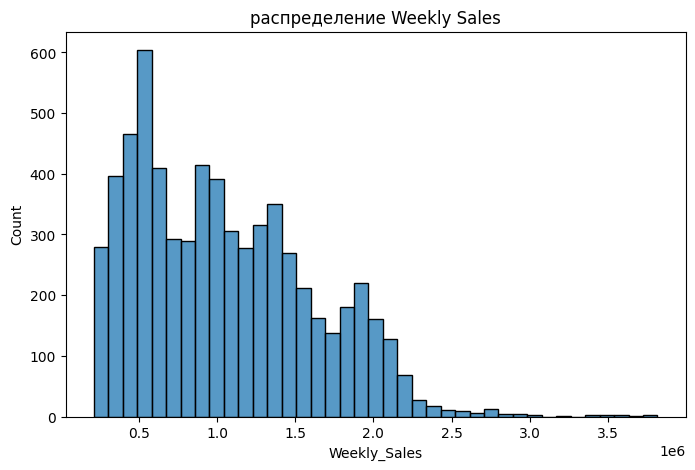

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['Weekly_Sales'])
plt.title('распределение Weekly Sales')
plt.show()

Ось X - это размер недельных продаж. справа в углу  1e6 - это число * 1.000.000 (то есть 0,5 * 1 000 000 = 500 000 и т. д.). Ось Y - количество наблюдений. Гистограмма показывает, что чаще всего продажи составляли ~ 300 000 - 1 500 000 - это "нормальные" недели, а все, что больше - это редкие значения (правосторонее смещение - редкие, но большие значения). Это может негативно влиять на линейные модели и требует аккуратного выбора метрик.

#### продажи по времени

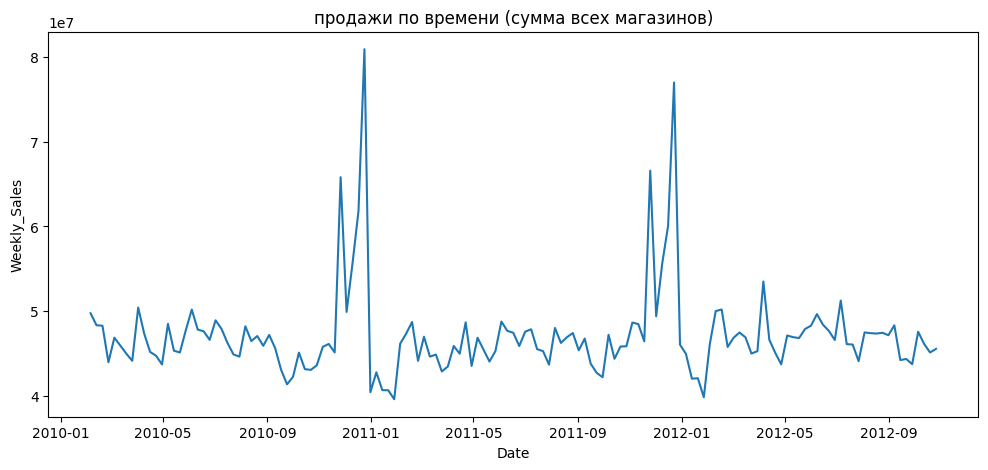

In [39]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) # преобразуем дату в формат datetime

daily_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index() # группируем строки по дате и суммируем недельные продажи

plt.figure(figsize=(12,5))
sns.lineplot(data=daily_sales, x='Date', y='Weekly_Sales')
plt.title('продажи по времени (сумма всех магазинов)')
plt.show()

Гозиронтальная ось линейного графика показывает даты, а вертикальная - суммы продаж всех магазинов. Замечаем тенденцию, что продажи возрастают в декабре (Новый год/Рождество) и резко спадают в начале календарного года. Могу предположить, что это из-за финансового цикла потребителей, которые тратят премии и авансы в декабре, а в январе переходят в режим экономии.

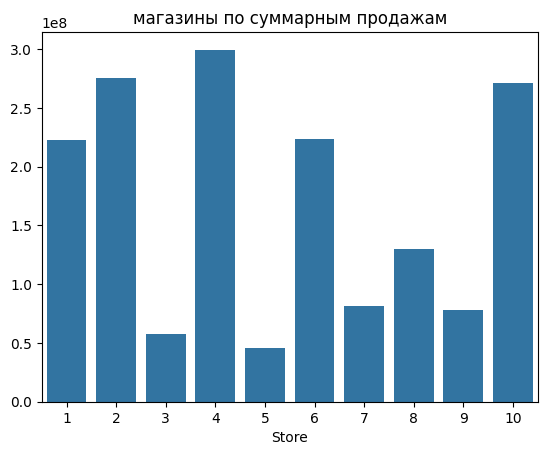

In [40]:
top_stores = df.groupby('Store')['Weekly_Sales'].sum().head(10)
sns.barplot(x=top_stores.index, y=top_stores.values)
plt.title('магазины по суммарным продажам')
plt.show()

Различные магазины демонстрируют существенно разные уровни продаж, что подтверждает необходимость учитывать идентификатор магазина как признак при построении модели. 

#### 